# Project Summary

This project focuses on predicting chemical toxicity using the Tox21 dataset.  
Each molecule is represented by its SMILES string and tested against 12 biological assays related to Nuclear Receptor (NR) and Stress Response (SR) pathways.

The workflow includes:
- Loading and inspecting the Tox21 dataset
- Handling missing assay values and class imbalance
- Generating molecular descriptors and fingerprints from SMILES using RDKit
- Exploring descriptor distributions before and after normalization
- Training multiple machine learning models for each toxicity assay
- Selecting the best model per assay based on cross-validated F1 score

The final outcome is a set of optimized binary classification models that can predict toxic or non-toxic behavior of molecules for individual biological targets.

In [ ]:
# -- General --
import joblib
import os

# -- EDA and Preprocessing --
import pandas as pd
import numpy as np

# -- Visualization --
import seaborn as sns
import matplotlib.pyplot as plt

# -- RDKit --
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors, Lipinski, Descriptors, Crippen
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# -- Machine Learning --
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# -- Preprocessing --
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
# -- Metrics --
from sklearn.metrics import f1_score

import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning
)

## 1. Loading Data
---

In [2]:
# Loading Data 
df_tox = pd.read_csv('../data/tox21.csv')

In [3]:
print(f'The rows in the dataset are {df_tox.shape[0]} and the columns are {df_tox.shape[1]}!\n')
print(f'The columns in the dataset are:')

for no, col in enumerate(df_tox.columns, start=1):
    print(f'{no}. {col}')

The rows in the dataset are 7831 and the columns are 14!

The columns in the dataset are:
1. NR-AR
2. NR-AR-LBD
3. NR-AhR
4. NR-Aromatase
5. NR-ER
6. NR-ER-LBD
7. NR-PPAR-gamma
8. SR-ARE
9. SR-ATAD5
10. SR-HSE
11. SR-MMP
12. SR-p53
13. mol_id
14. smiles


### Tox21 Dataset Column Definitions

**Nuclear Receptor (NR) Pathways**
* **`NR-AR`**: Tests if a chemical affects the Androgen (male hormone) receptor.
* **`NR-AR-LBD`**: Tests if a chemical binds to the active site of the Androgen receptor.
* **`NR-AhR`**: Tests if a chemical acts like toxic environmental pollutants.
* **`NR-Aromatase`**: Tests if a chemical blocks estrogen formation.
* **`NR-ER`**: Tests if a chemical affects the Estrogen (female hormone) receptor.
* **`NR-ER-LBD`**: Tests if a chemical binds to the active site of the Estrogen receptor.
* **`NR-PPAR-gamma`**: Tests if a chemical affects fat and metabolism control.

**Stress Response (SR) Pathways**
* **`SR-ARE`**: Tests if a chemical causes oxidative (cell) stress.
* **`SR-ATAD5`**: Tests if a chemical damages DNA during replication.
* **`SR-HSE`**: Tests if a chemical causes protein stress or misfolding.
* **`SR-MMP`**: Tests if a chemical damages mitochondria (cell energy).
* **`SR-p53`**: Tests if a chemical triggers DNA damage response or cell death.

### 🔎 Key Observations

- The dataset contains 7,831 molecules, each identified by a unique `mol_id` and a corresponding `smiles` string.
- There are 12 toxicity assay columns, covering Nuclear Receptor (NR) and Stress Response (SR) pathways.
- The dataset structure is suitable for multi-target binary classification, where each assay is treated as an independent prediction task.

## 2. Data Inspection
---

In [4]:
df_tox.shape

(7831, 14)

In [5]:
df_tox.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [6]:
# Reordering columns
cols = df_tox.columns.tolist()
cols = ['mol_id', 'smiles'] + [c for c in cols if c != 'smiles' and c != 'mol_id']
df_tox = df_tox[cols]

In [7]:
df_tox.head()

,mol_id,smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


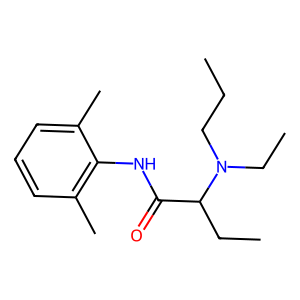

In [8]:
# Example  of Visualization of a molecule from DataSet
mol = Chem.MolFromSmiles("CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C")
Draw.MolToImage(mol)

In [9]:
df_tox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7831 entries, 0 to 7830
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mol_id         7831 non-null   object 
 1   smiles         7831 non-null   object 
 2   NR-AR          7265 non-null   float64
 3   NR-AR-LBD      6758 non-null   float64
 4   NR-AhR         6549 non-null   float64
 5   NR-Aromatase   5821 non-null   float64
 6   NR-ER          6193 non-null   float64
 7   NR-ER-LBD      6955 non-null   float64
 8   NR-PPAR-gamma  6450 non-null   float64
 9   SR-ARE         5832 non-null   float64
 10  SR-ATAD5       7072 non-null   float64
 11  SR-HSE         6467 non-null   float64
 12  SR-MMP         5810 non-null   float64
 13  SR-p53         6774 non-null   float64
dtypes: float64(12), object(2)
memory usage: 856.6+ KB


In [10]:
df_tox.columns

Index(['mol_id', 'smiles', 'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
       'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE',
       'SR-MMP', 'SR-p53'],
      dtype='object')

In [11]:
target_columns = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
                  'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 
                  'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

summary = pd.DataFrame({
    "null_count": df_tox[target_columns].isna().sum(),
    "non_null_count": df_tox[target_columns].notna().sum(),
    "null_%": (df_tox[target_columns].isna().mean() * 100).round(2),

    # class counts (ignore NaNs automatically)
    "count_0": (df_tox[target_columns] == 0).sum(),
    "count_1": (df_tox[target_columns] == 1).sum(),

    # percentage of positive class
    "%_ones": ((df_tox[target_columns] == 1).sum()
                / df_tox[target_columns].notna().sum()
                * 100).round(2)

}).sort_values("null_count", ascending=False)

summary

,null_count,non_null_count,null_%,count_0,count_1,%_ones
SR-MMP,2021,5810,25.81,4892,918,15.80
NR-Aromatase,2010,5821,25.67,5521,300,5.15
SR-ARE,1999,5832,25.53,4890,942,16.15
NR-ER,1638,6193,20.92,5400,793,12.80
NR-PPAR-gamma,1381,6450,17.64,6264,186,2.88
SR-HSE,1364,6467,17.42,6095,372,5.75
NR-AhR,1282,6549,16.37,5781,768,11.73
NR-AR-LBD,1073,6758,13.70,6521,237,3.51
SR-p53,1057,6774,13.50,6351,423,6.24
NR-ER-LBD,876,6955,11.19,6605,350,5.03


In [12]:
df_tox.columns

Index(['mol_id', 'smiles', 'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
       'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE',
       'SR-MMP', 'SR-p53'],
      dtype='object')

### 🔎 Key Observations

- Each assay is a binary label where:
  - `0` indicates non-toxic (inactive)
  - `1` indicates toxic (active)
- All assay columns contain missing values, indicating that not every molecule was tested against every biological target.
- The percentage of missing values varies across assays, with some targets having more than 25% missing data.
- The class distribution is highly imbalanced:
  - Most molecules are labeled as non-toxic (0)
  - Toxic (1) samples are comparatively rare
- This imbalance highlights the need for appropriate evaluation metrics (F1 score) and balanced learning strategies during modeling.

## 3. Feature Engineering
---

In [13]:
def calculate_descriptors_safe(smiles):
    """
    Calculates multiple molecular descriptors from a SMILES string.
    Returns a pandas Series so it can add multiple columns at once.
    Output schema is IDENTICAL to the original function.
    """
    morgan_gen = GetMorganGenerator(radius=3, fpSize=2048)
    try:
        # 1. Safely create and sanitize molecule
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is None:
            raise ValueError("Invalid SMILES")

        # 2. Remove explicit hydrogens (fixes H-without-neighbors warning)
        mol = Chem.RemoveHs(mol)

        # 3. Calculate descriptors (same as before)
        return pd.Series({
            'tpsa': rdMolDescriptors.CalcTPSA(mol),
            'mw':   Descriptors.MolWt(mol),
            'hbd':  Descriptors.NumHDonors(mol),
            'hba':  Descriptors.NumHAcceptors(mol),
            'rot':  Descriptors.NumRotatableBonds(mol),
            'logp': Crippen.MolLogP(mol),
            'mr':   Crippen.MolMR(mol),
            'hac':  Lipinski.HeavyAtomCount(mol),
            'fp':   morgan_gen.GetFingerprint(mol),  # 🔥 NO deprecation warning
            'ring_count': rdMolDescriptors.CalcNumRings(mol)
        })

    except Exception:
        # 4. Fail safely (same NaN structure as original)
        return pd.Series({
            'tpsa': np.nan,
            'mw': np.nan,
            'hbd': np.nan,
            'hba': np.nan,
            'rot': np.nan,
            'logp': np.nan,
            'mr': np.nan,
            'hac': np.nan,
            'fp': np.nan,
            'ring_count': np.nan
        })

# Apply the function (Creating all columns in one go)
# This returns a new DataFrame with the descriptor columns
descriptor_cols = df_tox['smiles'].apply(calculate_descriptors_safe)

# Join these new columns back to your original DataFrame
df_tox = pd.concat([df_tox, descriptor_cols], axis=1)

# Check for failures (just checking one column is enough since they all fail together)
print(f"Failed rows: {df_tox['tpsa'].isna().sum()}")

[14:07:51] WARNING: not removing hydrogen atom without neighbors
[14:07:51] WARNING: not removing hydrogen atom without neighbors
[14:07:52] Explicit valence for atom # 8 Al, 6, is greater than permitted
[14:07:53] Explicit valence for atom # 3 Al, 6, is greater than permitted
[14:07:53] Explicit valence for atom # 4 Al, 6, is greater than permitted
[14:07:54] Explicit valence for atom # 4 Al, 6, is greater than permitted
[14:07:54] Explicit valence for atom # 9 Al, 6, is greater than permitted
[14:07:55] Explicit valence for atom # 5 Al, 6, is greater than permitted
[14:07:55] Explicit valence for atom # 16 Al, 6, is greater than permitted
[14:07:56] Explicit valence for atom # 20 Al, 6, is greater than permitted


Failed rows: 8


In [14]:
# Filter for rows where TPSA is NaN (empty)
invalid_rows = df_tox[df_tox['hbd'].isna()].index

# Display just the SMILES strings that failed
print("Invalid SMILES strings:")
print(invalid_rows)

df_tox = df_tox.drop(index=invalid_rows).reset_index(drop=True)

Invalid SMILES strings:
Index([1322, 2290, 2297, 3558, 4565, 4649, 5538, 6723], dtype='int64')


In [15]:
# Filter for rows where TPSA is NaN (empty)
invalid_rows = df_tox[df_tox['hbd'].isna()].index

# Display just the SMILES strings that failed
print("Invalid SMILES strings:")
print(invalid_rows)

Invalid SMILES strings:
Index([], dtype='int64')


In [16]:
df_tox.shape

(7823, 24)

In [17]:
df_tox.head(1)

,mol_id,smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,...,tpsa,mw,hbd,hba,rot,logp,mr,hac,fp,ring_count
0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,...,82.28,258.324,1.0,5.0,3.0,1.3424,62.1622,16.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0


### 🔎 Key Observations

- SMILES strings were converted into numerical features because machine learning models cannot directly interpret chemical strings.
- Molecular descriptors such as TPSA, molecular weight, hydrogen bond counts, and rotatable bonds capture physicochemical properties of molecules.
- Morgan fingerprints (2048 bits) encode structural sub-patterns and substructures present in each molecule.
- A small number of invalid SMILES failed RDKit processing and were safely removed to maintain data quality.
- The combination of scalar descriptors and fingerprints provides both global chemical properties and detailed structural information for toxicity prediction.

## 4. Descriptor Distribution Analysis
---

In [32]:
cols = ['tpsa', 'mw', 'logp', 'hbd', 'hba', 'rot', 'mr', 'hac', 'ring_count']

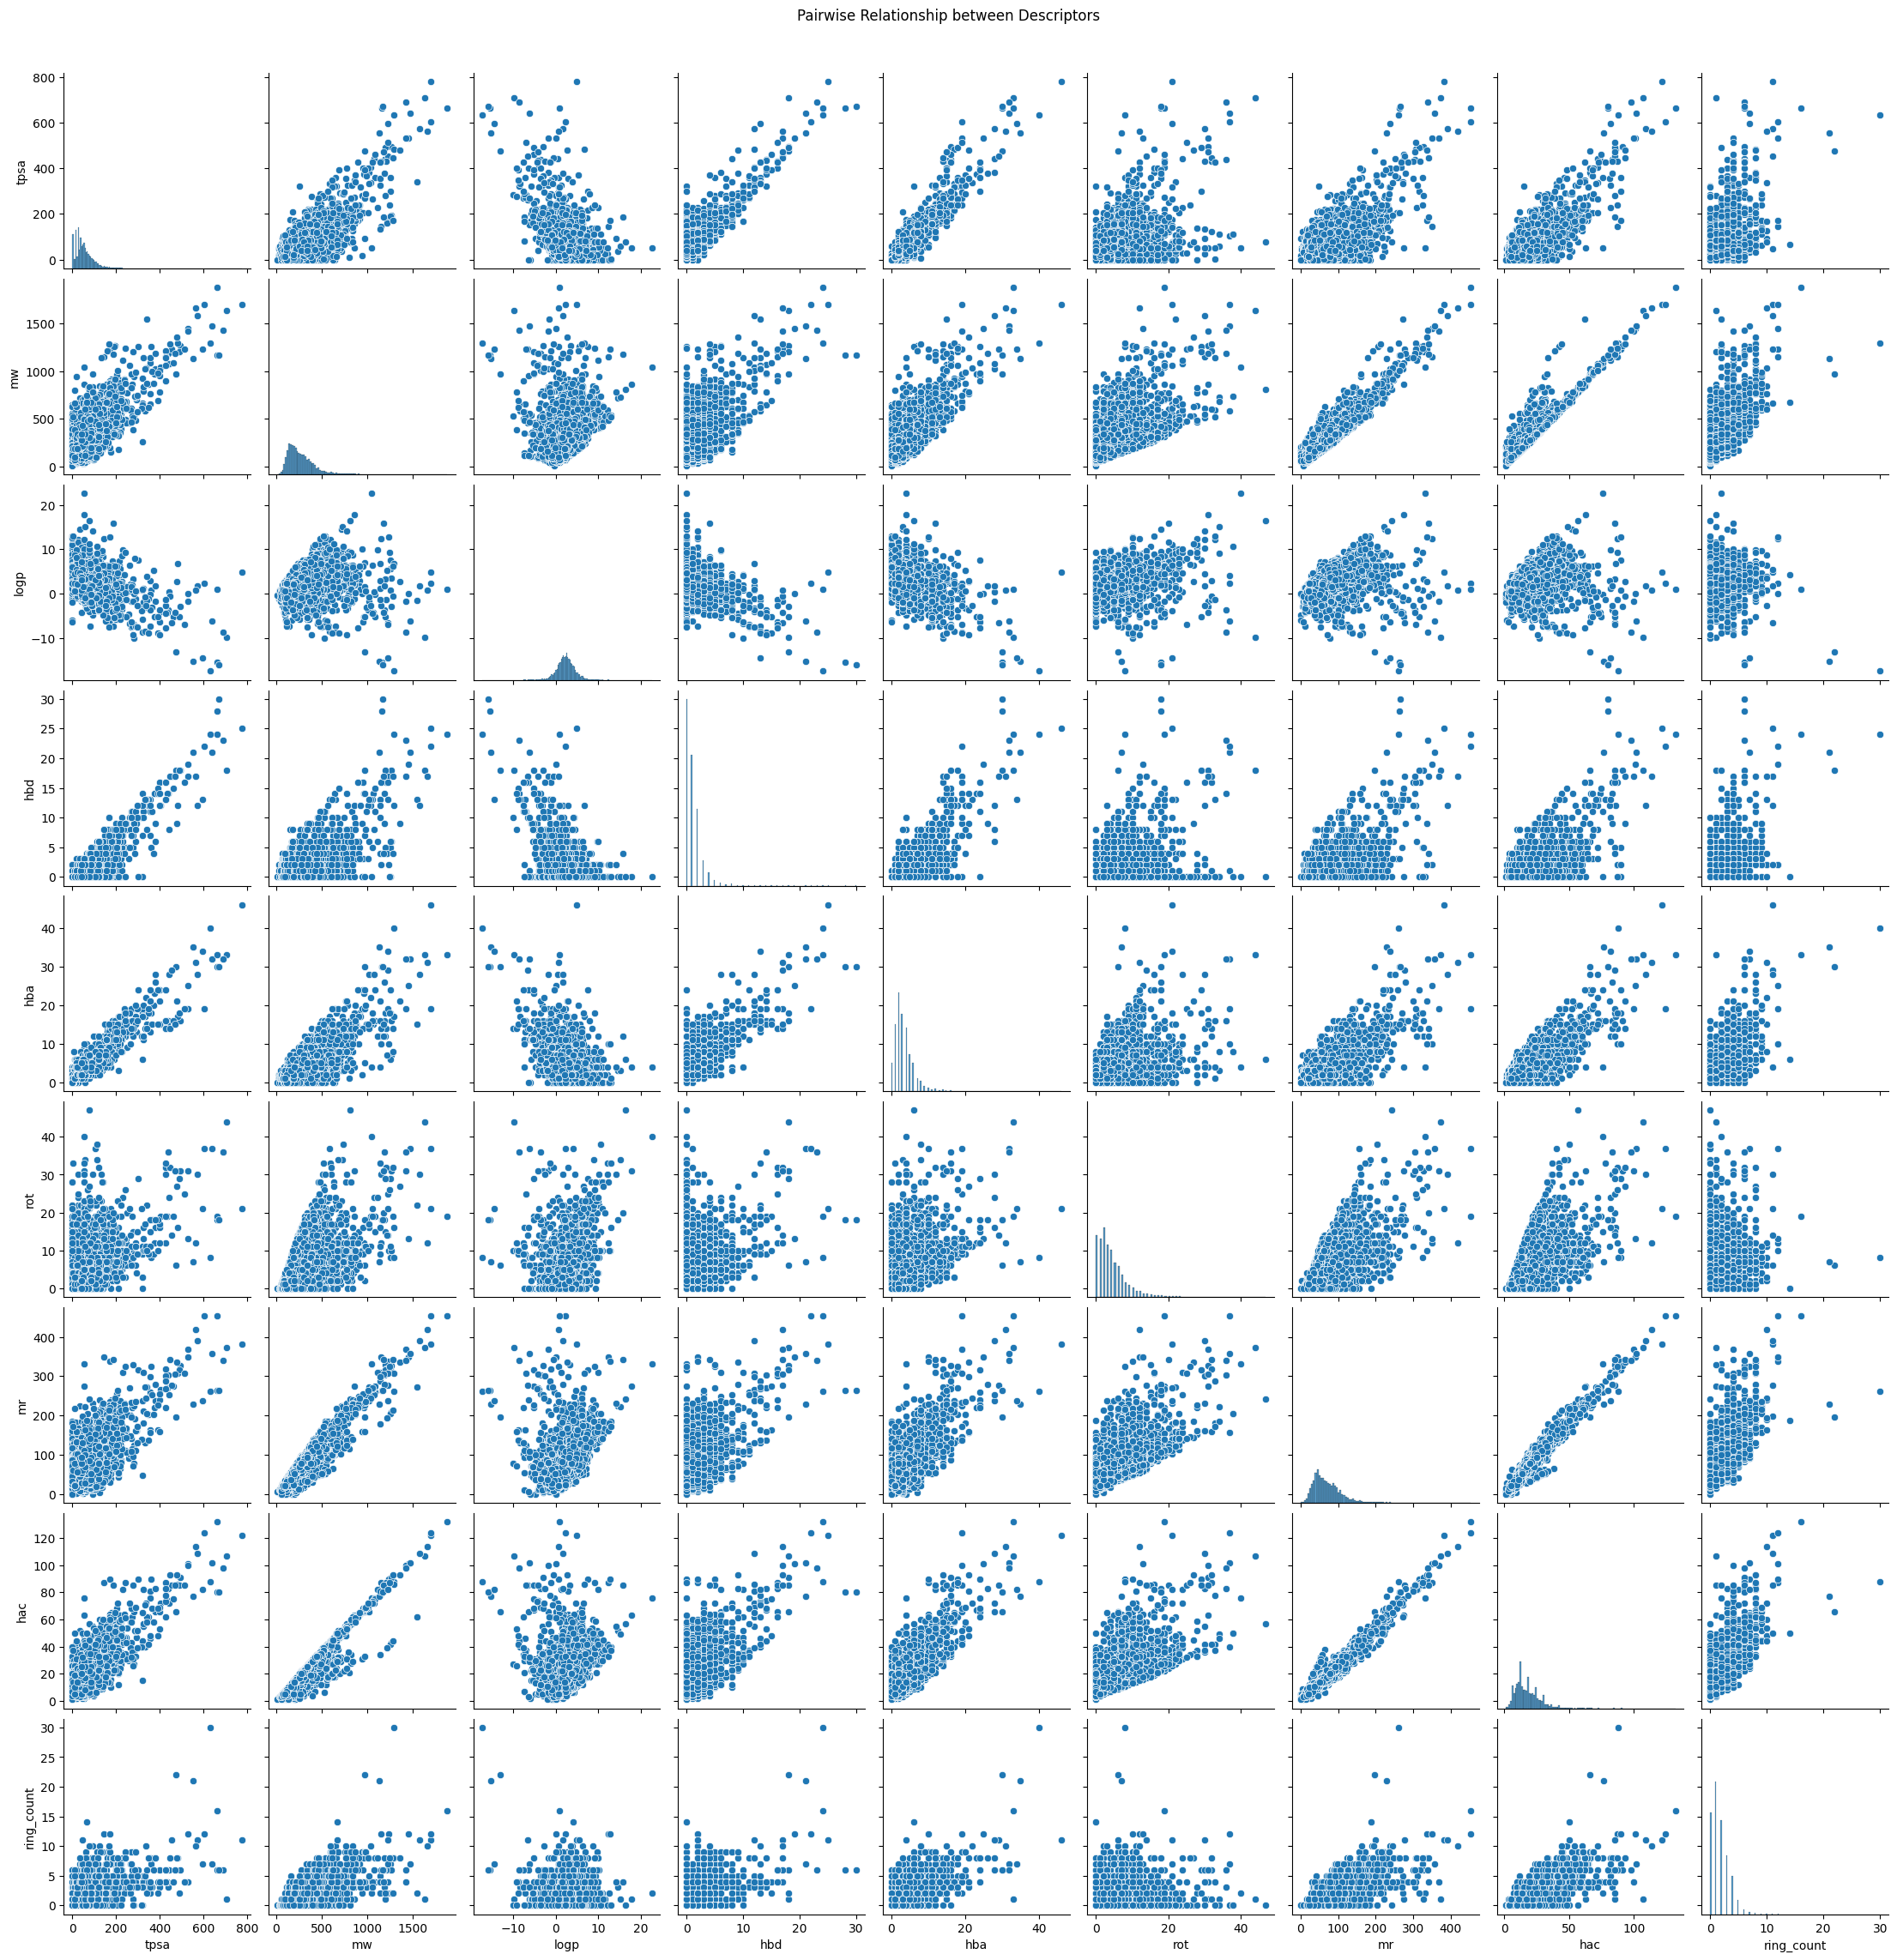

In [33]:
sns.pairplot(df_tox[cols])

# Add title
plt.suptitle('Pairwise Relationship between Descriptors', y=1.02)

# Show plot
plt.show()

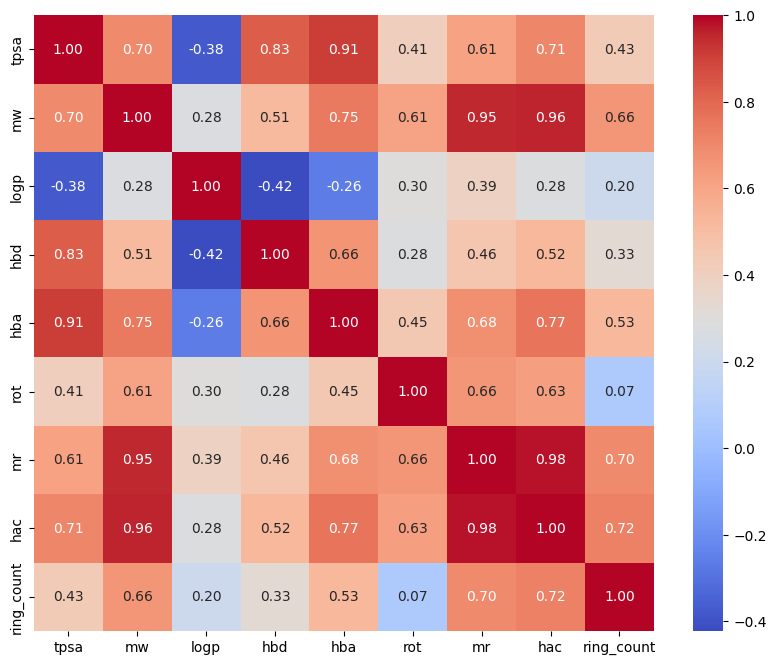

In [34]:
corr_matrix = df_tox[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

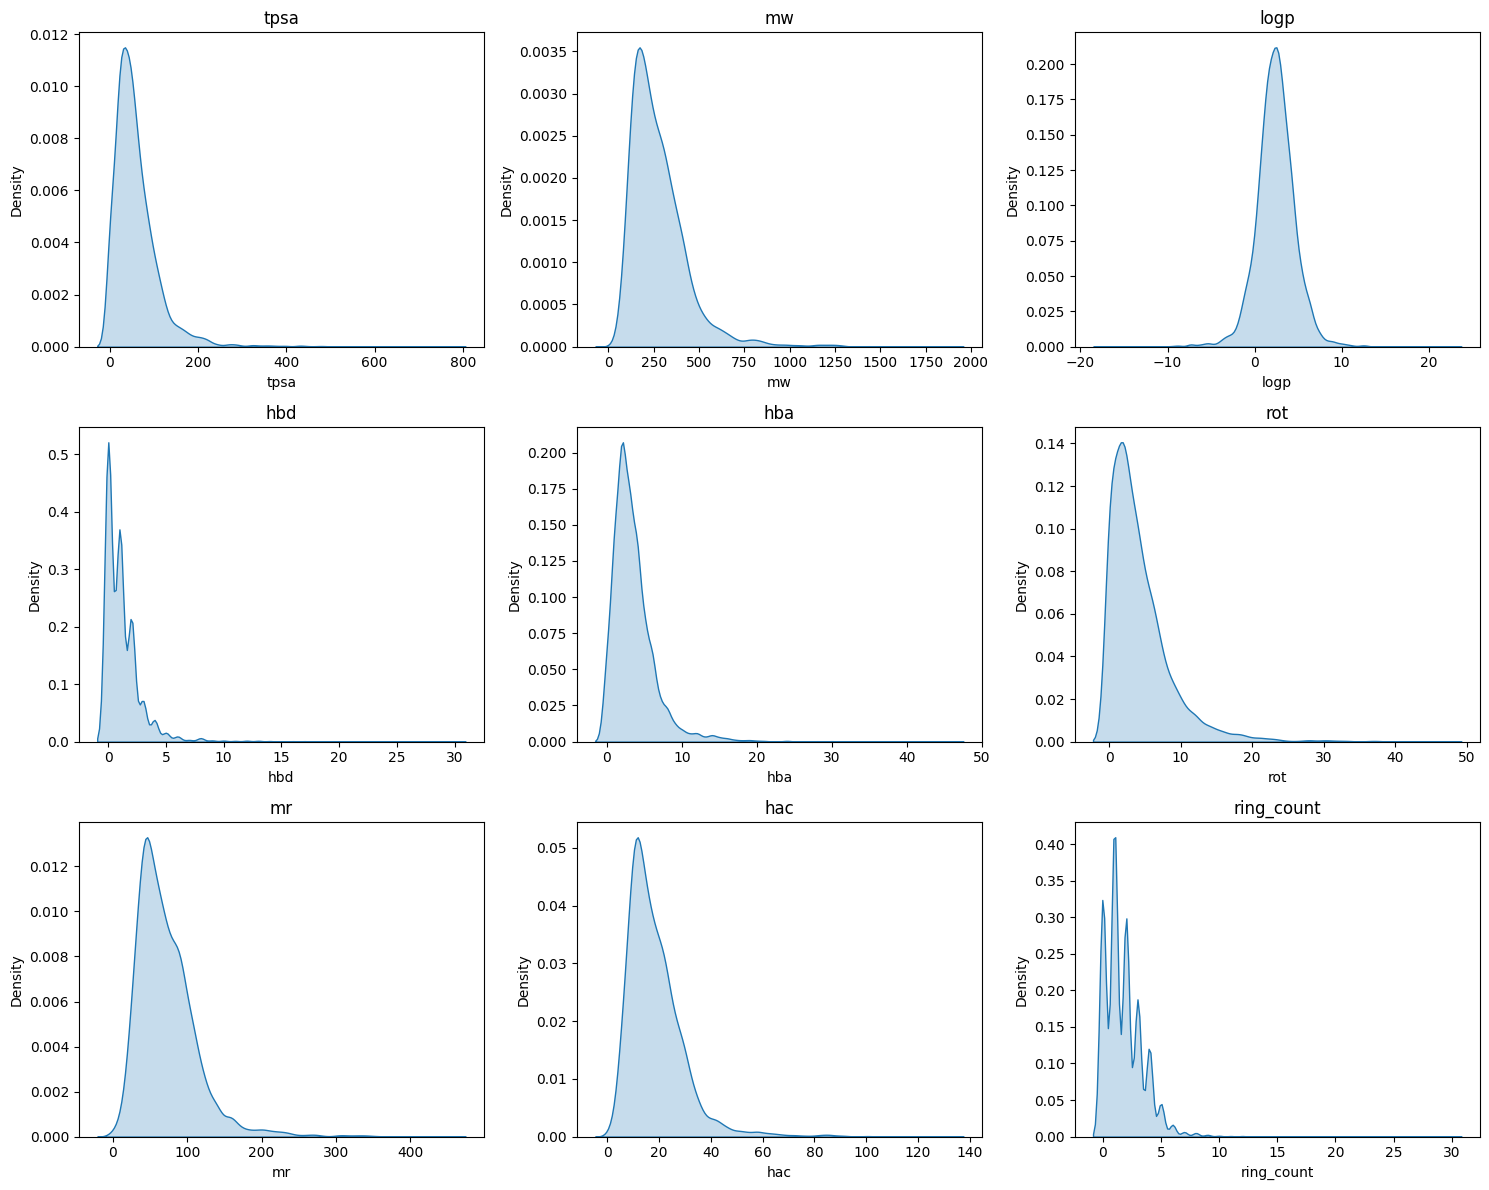

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.kdeplot(data=df_tox, x=col, fill=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots if cols < 9
for j in range(len(cols), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(r'..\plots\1.Descriptor_without_normalization.png')
plt.show()


### 🔎 Key Observations

- Most molecular descriptors show right-skewed distributions, which is common for chemical property data.
- Properties such as molecular weight, TPSA, and rotatable bonds span a wide range of values.
- The presence of skewness suggests that direct use of raw values may negatively impact certain machine learning models.
- Visual inspection confirms the need for normalization to stabilize variance and improve model learning.

## 5. Power Transformation & Normalization
---

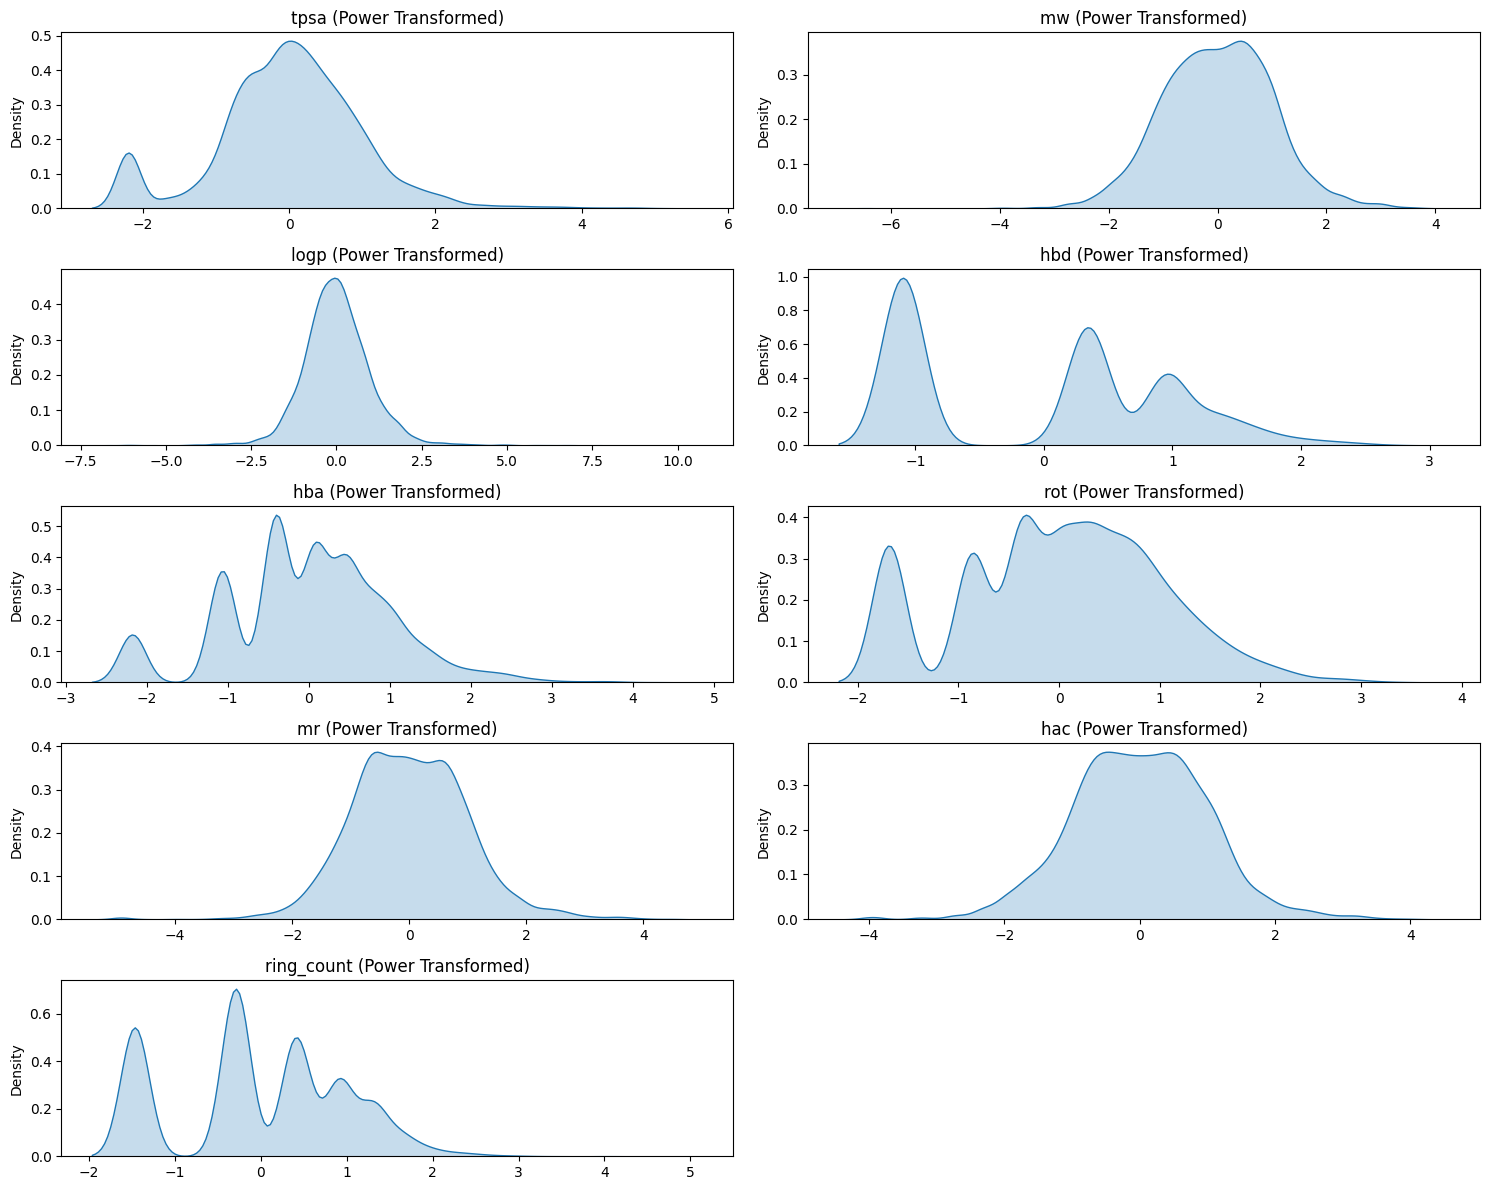

In [19]:
n_rows = (len(cols) + 1) // 2  
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    pt = PowerTransformer()
    transformed = pt.fit_transform(df_tox[[col]]).ravel()

    sns.kdeplot(x=transformed, fill=True, ax=axes[i])
    axes[i].set_title(f"{col} (Power Transformed)")

# remove unused axes
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(r'..\plots\2.Descriptor_with_normalization.png')
plt.show()


In [20]:
def normalize(df):
    pt = PowerTransformer(method="yeo-johnson")
    to_normal = ['hac', 'mw', 'mr', 'hba', 'tpsa', 'rot']
    df[to_normal] = pt.fit_transform(df[to_normal])
    return df

In [21]:
# Converting fingerprint to numpy array
def to_array(fp):
    arr = np.zeros(fp.GetNumBits(), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fp_array = df_tox['fp'].apply(to_array)

df_tox['fp'] = fp_array
df_tox_normalize = df_tox.copy()

df_tox_normalize['fp'] = fp_array

### 🔎 Key Observations

- PowerTransformer (Yeo-Johnson) normalization was applied to selected molecular descriptors.
- After transformation, feature distributions become more symmetric and closer to a normal shape.
- Normalization is especially beneficial for distance-based and linear models such as Logistic Regression and KNN.
- Both normalized and non-normalized feature sets were evaluated to compare model performance.

## 6. Model Training & Evaluation
---

In [35]:
# Tox21 binary classification targets
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
           'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
           'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
            ]

# Scalar molecular descriptors
scalar_cols = ['tpsa', 'mw', 'hbd', 'hba', 'rot',
               'logp', 'ring_count' # , 'mr', 'hac'
                ]

In [36]:
models_config = {
    "LR": make_pipeline(StandardScaler(), LogisticRegression(solver="lbfgs", class_weight="balanced", max_iter=500)),
    "RF": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=24),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    "XGB": XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", n_jobs=-1, random_state=24),
    "LGBM_Bal": LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=24),
    "LGBM_Unbal": LGBMClassifier(is_unbalance=True, verbosity=-1, random_state=24)
}

In [37]:
def cross_val_f1(model, X, y, n_splits=5):
    """
    Returns mean F1 score for class 1 using Stratified K-Fold CV
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model_fold = clone(model)
        model_fold.fit(X_train, y_train)

        y_pred = model_fold.predict(X_val)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)

        f1_scores.append(f1)

    return np.mean(f1_scores)

In [38]:
# Running ML models without normalizing the data

results = {t: {} for t in targets}
best_models_store = {}

for target in targets:
    print(f"\n>>> Target: {target}")

    # Remove missing labels
    df_sub = df_tox[df_tox[target].notna()]
    y = df_sub[target].values

    # Combine scalar + fingerprint features
    X_scalar = df_sub[scalar_cols].values
    X_fp = np.stack(df_sub["fp"].values)
    X = np.hstack([X_scalar, X_fp])

    best_f1 = -1
    best_model = None
    best_model_name = None

    for name, model in models_config.items():
        mean_f1 = cross_val_f1(model, X, y)
        results[target][name] = mean_f1

        print(f"{name} | CV F1: {mean_f1:.4f}")

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_model = clone(model)
            best_model_name = name

    # Refit best model on full dataset
    best_model.fit(X, y)

    print(f"✅ Best model: {best_model_name} | F1: {best_f1:.4f}")


>>> Target: NR-AR
LR | CV F1: 0.4024
RF | CV F1: 0.6045
KNN | CV F1: 0.4663
XGB | CV F1: 0.5971
LGBM_Bal | CV F1: 0.5216
LGBM_Unbal | CV F1: 0.5222
✅ Best model: RF | F1: 0.6045

>>> Target: NR-AR-LBD
LR | CV F1: 0.5557
RF | CV F1: 0.6349
KNN | CV F1: 0.4682
XGB | CV F1: 0.6498
LGBM_Bal | CV F1: 0.6668
LGBM_Unbal | CV F1: 0.6779
✅ Best model: LGBM_Unbal | F1: 0.6779

>>> Target: NR-AhR
LR | CV F1: 0.4439
RF | CV F1: 0.3869
KNN | CV F1: 0.1703
XGB | CV F1: 0.5272
LGBM_Bal | CV F1: 0.5796
LGBM_Unbal | CV F1: 0.5751
✅ Best model: LGBM_Bal | F1: 0.5796

>>> Target: NR-Aromatase
LR | CV F1: 0.3222
RF | CV F1: 0.3026
KNN | CV F1: 0.1259
XGB | CV F1: 0.3987
LGBM_Bal | CV F1: 0.4070
LGBM_Unbal | CV F1: 0.3962
✅ Best model: LGBM_Bal | F1: 0.4070

>>> Target: NR-ER
LR | CV F1: 0.2740
RF | CV F1: 0.3151
KNN | CV F1: 0.1939
XGB | CV F1: 0.3662
LGBM_Bal | CV F1: 0.4031
LGBM_Unbal | CV F1: 0.4026
✅ Best model: LGBM_Bal | F1: 0.4031

>>> Target: NR-ER-LBD
LR | CV F1: 0.3273
RF | CV F1: 0.3545
KNN | 

c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn

RF | CV F1: 0.1543
KNN | CV F1: 0.0765
XGB | CV F1: 0.2852


c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warning

LGBM_Bal | CV F1: 0.3817


c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yashd\OneDrive\Desktop\GenAI\1. Jupyter\Projects\Molecular Optimizer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warning

LGBM_Unbal | CV F1: 0.3847
✅ Best model: LGBM_Unbal | F1: 0.3847


In [26]:
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [27]:
n_scalar = len(scalar_cols)
preprocess_pt = ColumnTransformer(transformers=[("pt", PowerTransformer(method="yeo-johnson"), list(range(n_scalar)))], remainder="passthrough")


In [28]:
models_config = {
    "LR": make_pipeline(preprocess_pt, StandardScaler(with_mean=False), LogisticRegression(solver="lbfgs", class_weight="balanced", max_iter=500, )),

    "KNN": make_pipeline(preprocess_pt, StandardScaler(with_mean=False), KNeighborsClassifier(n_neighbors=5)),

    "RF": RandomForestClassifier(random_state=24), #n_estimators=300,n_jobs=-1,),

    "XGB": XGBClassifier(), #n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",n_jobs=-1,random_state=24),

    "LGBM_Bal": LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=24),

    "LGBM_Unbal": LGBMClassifier(is_unbalance=True, verbosity=-1, random_state=24)
}


In [29]:
results_normalize = {t: {} for t in targets}
best_models_store_normalize = {}

for target in targets:
    print(f"\n>>> Target: {target}")

    # Remove missing labels
    df_sub = df_tox_normalize[df_tox_normalize[target].notna()]
    y = df_sub[target].values

    # Combine scalar + fingerprint features
    X_scalar = df_sub[scalar_cols].values
    X_fp = np.stack(df_sub["fp"].values)
    X = np.hstack([X_scalar, X_fp])

    best_f1 = -1
    best_model = None
    best_model_name = None

    for name, model in models_config.items():
        mean_f1 = cross_val_f1(model, X, y)
        results_normalize[target][name] = mean_f1

        print(f"{name} | CV F1: {mean_f1:.4f}")

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_model = clone(model)
            best_model_name = name

    # Refit best model on full dataset
    best_model.fit(X, y)

    # Save model to disk
    model_path = f"{MODEL_DIR}/{target}_best_model.joblib"
    joblib.dump(best_model, model_path)

    best_models_store_normalize[target] = {
        "model_name": best_model_name,
        "model_path": model_path,
        "best_cv_f1": best_f1
    }

    print(f"💾 Saved model to: {model_path}")
    print(f"✅ Best model: {best_model_name} | F1: {best_f1:.4f}")


>>> Target: NR-AR
LR | CV F1: 0.4024
KNN | CV F1: 0.4695
RF | CV F1: 0.6005
XGB | CV F1: 0.5884
LGBM_Bal | CV F1: 0.5271
LGBM_Unbal | CV F1: 0.5222
💾 Saved model to: ../models/NR-AR_best_model.joblib
✅ Best model: RF | F1: 0.6005

>>> Target: NR-AR-LBD
LR | CV F1: 0.5711
KNN | CV F1: 0.4771
RF | CV F1: 0.6241
XGB | CV F1: 0.6654
LGBM_Bal | CV F1: 0.6616
LGBM_Unbal | CV F1: 0.6603
💾 Saved model to: ../models/NR-AR-LBD_best_model.joblib
✅ Best model: XGB | F1: 0.6654

>>> Target: NR-AhR
LR | CV F1: 0.4417
KNN | CV F1: 0.1550
RF | CV F1: 0.3941
XGB | CV F1: 0.5181
LGBM_Bal | CV F1: 0.5671
LGBM_Unbal | CV F1: 0.5680
💾 Saved model to: ../models/NR-AhR_best_model.joblib
✅ Best model: LGBM_Unbal | F1: 0.5680

>>> Target: NR-Aromatase
LR | CV F1: 0.3186
KNN | CV F1: 0.1310
RF | CV F1: 0.2997
XGB | CV F1: 0.4104
LGBM_Bal | CV F1: 0.4067
LGBM_Unbal | CV F1: 0.3776
💾 Saved model to: ../models/NR-Aromatase_best_model.joblib
✅ Best model: XGB | F1: 0.4104

>>> Target: NR-ER
LR | CV F1: 0.2778
KNN 

In [39]:
results_df = pd.DataFrame(results).T

numeric_cols = results_df.select_dtypes(include="number")

results_df["Best_Model"] = numeric_cols.idxmax(axis=1)
results_df["Best_CV_F1"] = numeric_cols.max(axis=1)

results_df.to_csv("results_without_normalize.csv", index=False)
display(results_df.sort_values("Best_CV_F1", ascending=False))

,LR,RF,KNN,XGB,LGBM_Bal,LGBM_Unbal,Best_Model,Best_CV_F1
NR-AR-LBD,0.555717,0.634904,0.468190,0.649847,0.666761,0.677922,LGBM_Unbal,0.677922
SR-MMP,0.523866,0.515212,0.178910,0.632146,0.674608,0.654989,LGBM_Bal,0.674608
NR-AR,0.402385,0.604451,0.466336,0.597112,0.521558,0.522209,RF,0.604451
NR-AhR,0.443883,0.386936,0.170304,0.527161,0.579570,0.575097,LGBM_Bal,0.579570
SR-ARE,0.354593,0.274523,0.115862,0.409930,0.507995,0.510705,LGBM_Unbal,0.510705
NR-ER-LBD,0.327327,0.354484,0.248436,0.486630,0.492774,0.478177,LGBM_Bal,0.492774
NR-Aromatase,0.322194,0.302566,0.125869,0.398713,0.407047,0.396224,LGBM_Bal,0.407047
NR-ER,0.274035,0.315098,0.193925,0.366151,0.403138,0.402623,LGBM_Bal,0.403138
SR-p53,0.273919,0.154295,0.076511,0.285247,0.381660,0.384671,LGBM_Unbal,0.384671
SR-ATAD5,0.307037,0.063950,0.131566,0.201268,0.380984,0.363218,LGBM_Bal,0.380984


In [40]:
results_df_normalize = pd.DataFrame(results_normalize).T

numeric_cols = results_df_normalize.select_dtypes(include="number")

results_df_normalize["Best_Model"] = numeric_cols.idxmax(axis=1)
results_df_normalize["Best_CV_F1"] = numeric_cols.max(axis=1)

results_df_normalize.to_csv("results_with_normalize.csv", index=False)
display(results_df_normalize.sort_values("Best_CV_F1", ascending=False))

,LR,KNN,RF,XGB,LGBM_Bal,LGBM_Unbal,Best_Model,Best_CV_F1
SR-MMP,0.527561,0.192642,0.521032,0.654694,0.671556,0.664200,LGBM_Bal,0.671556
NR-AR-LBD,0.571092,0.477069,0.624141,0.665423,0.661583,0.660259,XGB,0.665423
NR-AR,0.402422,0.469451,0.600451,0.588366,0.527136,0.522190,RF,0.600451
NR-AhR,0.441673,0.155038,0.394137,0.518080,0.567128,0.568015,LGBM_Unbal,0.568015
SR-ARE,0.355901,0.124729,0.292795,0.426122,0.506830,0.515540,LGBM_Unbal,0.515540
NR-ER-LBD,0.335421,0.261134,0.390054,0.462548,0.498854,0.485081,LGBM_Bal,0.498854
NR-ER,0.277756,0.202934,0.329815,0.374593,0.406170,0.411484,LGBM_Unbal,0.411484
NR-Aromatase,0.318622,0.130984,0.299727,0.410441,0.406678,0.377553,XGB,0.410441
SR-p53,0.267749,0.076316,0.146531,0.297294,0.393049,0.377095,LGBM_Bal,0.393049
SR-ATAD5,0.313290,0.117886,0.077652,0.251378,0.356411,0.364271,LGBM_Unbal,0.364271


### 🔎 Key Observations

- Each toxicity assay was treated as an independent binary classification problem.
- Multiple machine learning models were evaluated, including Logistic Regression, Random Forest, KNN, XGBoost, and LightGBM.
- Stratified K-Fold cross-validation was used to handle class imbalance during model evaluation.
- F1 score was selected as the primary metric to balance precision and recall for the minority (toxic) class.
- LightGBM (balanced or unbalanced) and Random Forest models consistently showed the best performance across most assays.
- For each assay, the model with the highest cross-validated F1 score was selected as the final best model.
- Normalized molecular descriptors generally improved or maintained model performance compared to raw features.
- The selected best models were retrained on the full available dataset for each assay.
- Final trained models were saved to disk for future prediction, reuse, or deployment workflows.

## Project Conclusion
---
- In this project, a complete machine learning workflow to predict chemical toxicity using the `Tox21 dataset`. Starting from raw `SMILES` strings, molecular structures were converted into meaningful numerical representations using physicochemical descriptors and structural fingerprints. This allowed the models to capture both global chemical properties and detailed substructural information.

- Due to missing labels and strong class imbalance across toxicity assays, each biological target was modeled as an independent binary classification task and evaluated using stratified cross-validation. The `F1 score` was used as the primary metric to ensure balanced performance on the `minority toxic class`.

- Multiple machine learning algorithms were compared, and ensemble-based models, particularly `LightGBM` and `Random Forest`, consistently achieved the best performance across most assays. Feature normalization generally improved model stability without degrading performance. The final optimized models were retrained on all available data and saved for downstream reuse.

###  **Overall, this study demonstrates that combining chemically meaningful descriptors with robust machine learning techniques provides an effective and scalable approach for in silico toxicity screening, supporting early-stage chemical safety assessment and drug discovery workflows.**
